In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import ast
import os
import json
import math


# Define Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RNA2D_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [ ]:

json_file = '/content/EternaBench_Riboswitch_Filtered_23May2022.json.zip'


data = pd.read_json(json_file)

dataset = RNA2D_Dataset(data)
print(len(dataset))
print(data.head())

import pandas as pd

# Assuming 'data' is your dataframe loaded from the .json file

# Reset the index of the dataframe, which will assign a new index starting from 0
#data_reset = data.reset_index(drop=True)

# If you want to save this new dataframe back to a .json file, you can do so as follows:
#data_reset.to_json('reindexed_data.json', orient='records', indent=2)

# Display the first few rows of the new dataframe to verify
#print(data_reset.head())

#dataset = RNA2D_Dataset(data_reset)


7228
   Activation Ratio Design  Folding_Subscore  KDFMN       KDOFF        KDON  \
0          0.985644   None               NaN    NaN    8.688763    8.815313   
1          0.638712   None               NaN    NaN   68.275500  106.895529   
2          1.195391   None               NaN    NaN    9.479632    7.930152   
3          0.827836   None               NaN    NaN   37.213889   44.953230   
4          1.002273   None               NaN    NaN  198.475109  198.024952   

   KDnoFMN      Kd_OFF       Kd_ON  NumberOfClusters  ...  \
0      NaN    8.688763    8.815313               NaN  ...   
1      NaN   68.275500  106.895529               NaN  ...   
2      NaN    9.479632    7.930152               NaN  ...   
3      NaN   37.213889   44.953230               NaN  ...   
4      NaN  198.475109  198.024952               NaN  ...   

                                         lig_aptamer  \
0  ..........(xxxxx(.................)xxxxxx).......   
1  ..........(xxxxxx(....................

# Define Model

In [ ]:
! pip install einops

In [ ]:
import sys

sys.path.append("/content/ribonanzanet2d-final/")

from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config):
        config.dropout=0.3
        super(finetuned_RibonanzaNet, self).__init__(config)

        self.dropout=nn.Dropout(0.0)
        self.ct_predictor=nn.Linear(64,1)

    def forward(self,src):

        #with torch.no_grad():
        _, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        pairwise_features=pairwise_features+pairwise_features.permute(0,2,1,3) #symmetrize

        output=self.ct_predictor(self.dropout(pairwise_features)) #predict

        return output.squeeze(-1)

In [ ]:
model=finetuned_RibonanzaNet(load_config_from_yaml("/content/ribonanzanet2d-final/configs/pairwise.yaml"))

constructing 9 ConvTransformerEncoderLayers


In [ ]:
model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_location='cpu'))

<ipython-input-46-40bfaf6b5862>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_loca

<All keys matched successfully>

In [ ]:
print(len(dataset))

7228


In [ ]:
dataset[0]

{'sequence': tensor([1, 2, 0, 3, 1, 1, 3, 3, 2, 1, 0, 2, 0, 0, 2, 2, 0, 1, 3, 0, 0, 0, 0, 1,
         1, 0, 0, 0, 3, 0, 1, 1, 0, 2, 3, 0, 2, 2, 0, 3, 0, 3, 2, 1, 0, 0, 1, 0,
         3, 2, 0, 2, 2, 0, 3, 1, 0, 1, 1, 1, 0, 3, 2, 3, 2, 0, 1, 2, 0, 0, 2, 2,
         0, 3, 2, 1, 2, 2, 2, 0, 0, 0, 3, 0])}

# Make predictions

In [ ]:
from tqdm import tqdm


test_preds = []
model.eval()

for i in tqdm(range(len(dataset))):
    # Access the item correctly for a PyTorch Dataset
    example = dataset[i]
    sequence = example['sequence'].cuda().unsqueeze(0)

    with torch.no_grad():
        test_preds.append(model(sequence).sigmoid().cpu().numpy())





  0%|          | 0/7228 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 7228/7228 [04:59<00:00, 24.12it/s]


In [ ]:
print(test_preds[0])

[[[4.1844929e-14 1.2397073e-13 5.9657405e-12 ... 1.2358697e-07
   2.3134473e-06 3.5345243e-04]
  [1.2397073e-13 3.1295902e-14 1.6928443e-13 ... 1.1316718e-06
   8.8668712e-06 9.0036490e-05]
  [5.9657405e-12 1.6928443e-13 3.4381660e-14 ... 3.1597931e-08
   5.3474598e-09 2.6101196e-08]
  ...
  [1.2358697e-07 1.1316718e-06 3.1597931e-08 ... 8.9895903e-16
   1.2191494e-17 6.4701230e-15]
  [2.3134473e-06 8.8668712e-06 5.3474598e-09 ... 1.2191494e-17
   2.7062180e-15 7.4790934e-15]
  [3.5345243e-04 9.0036490e-05 2.6101196e-08 ... 6.4701230e-15
   7.4790934e-15 1.2615207e-17]]]


In [ ]:
import pickle

# Path to save the file
save_path = '/content/RibonanzaNet_Riboswitch_preds_all_filtered.pkl'

# Save the list of lists to a pickle file
with open(save_path, 'wb') as f:
    pickle.dump(test_preds, f)

print(f"test_preds saved to {save_path}")


test_preds saved to /content/RibonanzaNet_Riboswitch_preds_all_filtered.pkl


In [ ]:


# Path to load the file
load_path = '/content/RibonanzaNet_Riboswitch_preds_all_filtered.pkl'

# Load the list of lists from the pickle file
with open(load_path, 'rb') as f:
    test_preds = pickle.load(f)

print(f"test_preds loaded from {load_path}")


test_preds loaded from /content/RibonanzaNet_Riboswitch_preds_all_filtered.pkl


7228


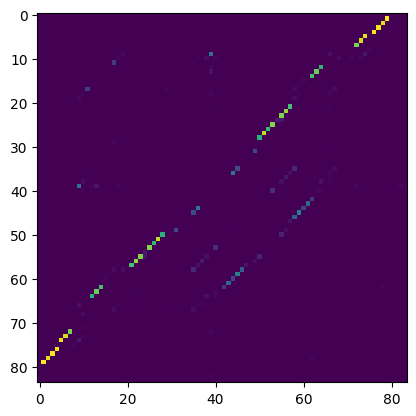

In [ ]:
# let's take a look at the predictions

plt.imshow(test_preds[1][0])
print(len(test_preds))

### Convert bpp matrices to punp vectors.

In [ ]:
bpp_vector_list = []
for i in range(len(test_preds)):
    bpp_vector_list.append(1-np.sum((test_preds[i][0]), axis=0))


print(len(bpp_vector_list[0]))
len(bpp_vector_list)

84


7228

## Adjustment , so I thought based on riboswitch utils, that riboswitches were scored with reactivity and probability vectors, but bpp vectors not necessary if you have bpp matrix.

###Use BPP matrics to compute theoretical KD, by extracting bpp coordinate of terminal ms2 hairpin

##First grab bpp matrix coordinate from ribonanzaNet prediction of MS2 aptamer


In [ ]:
ms2_apt_file = '/content/ms2apt_sequence.csv'
ms2_apt_data = pd.read_csv(ms2_apt_file)
ms2_apt_dataset = RNA2D_Dataset(ms2_apt_data)

In [ ]:
from tqdm import tqdm
import torch

ms2_apt_preds = []
model.eval()

for i in tqdm(range(len(ms2_apt_data))):
    # Access the item correctly for a PyTorch Dataset
    example = ms2_apt_dataset[i]
    sequence = example['sequence'].unsqueeze(0)

    with torch.no_grad():
        ms2_apt_preds.append(model(sequence).sigmoid().cpu().numpy())

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


In [ ]:
EPSILON = 1e-13

#compute P(ref) without flanking sequences for RibonanzaNet
def compute_bp_kfold_ref():
	return ms2_apt_preds[0][0][0][-1]+EPSILON

def compute_bp_kfold_ref_with_flanking():
    return ms2_apt_preds[0][0][15][-16]+EPSILON

In [ ]:
compute_bp_kfold_ref()

0.9921637773514794

In [ ]:
compute_bp_kfold_ref_with_flanking()

0.9990835189820336

## Checking code to make sure MS2_aptamer is found correctly

In [ ]:
ms2_aptamer = "ACAUGAGGAUCACCCAUGU"
example = data.iloc[3]['sequence']
first_a_index = example.find(ms2_aptamer) + ms2_aptamer.find('A')
last_u_index = example.find(ms2_aptamer) + ms2_aptamer.rfind('U')
print(example)
print(first_a_index)
print(last_u_index)
len(example)
example[63]
example[81]

AAUCAACUUAGAGGAUAUAAGCUUAAAAUAGGGUUAGAAGGCUAUGGUACUAAUGAUCCGUCAACAUGAGGAUCACCCAUGUAG
63
81


'U'

In [ ]:
# Define the MS2 aptamer sequence and reference p_ref value
ms2_aptamer = "ACAUGAGGAUCACCCAUGU"
p_ref = compute_bp_kfold_ref()  # Replace with your actual p_ref value

# List to store the computed p_est and K_s values
p_est_list = []

def extract_p_est_from_bpp(bpp_matrix, ms2_start_idx, ms2_end_idx):
    p_est = bpp_matrix[ms2_start_idx, ms2_end_idx] + EPSILON  # Extract the base pairing probability
    return p_est

# Iterate over the sequences and extract the p_est values
for i, sequence in enumerate(data['sequence']):
    first_a_index = sequence.find(ms2_aptamer) + ms2_aptamer.find('A')
    last_u_index = sequence.find(ms2_aptamer) + ms2_aptamer.rfind('U')

    # Ensure the MS2 aptamer was found
    if first_a_index == -1 or last_u_index == -1:
        print(f"MS2 aptamer not found in sequence {i}")
        p_est_list.append(None)
        continue

    try:
        bpp_matrix = test_preds[i][0]  # Get the bpp matrix for the current sequence

        # Extract p_est value using the modified MS2 aptamer sequence
        p_est = extract_p_est_from_bpp(bpp_matrix, first_a_index, last_u_index)
        p_est_list.append(p_est)

    except IndexError as e:
        print(f"IndexError for sequence {i}: {str(e)}")
        p_est_list.append(None)  # Append None or a default value if an error occurs


# Compute K_s for each sequence
ks_list = [p_ref / p_est for p_est in p_est_list]

# Compute the logarithm of K_s for each sequence
log_kfold_est_RibonanzaNet = [math.log(ks) for ks in ks_list]

# Add the new column to the DataFrame
data['log_kfold_est_RibonanzaNet'] = log_kfold_est_RibonanzaNet

# Convert the DataFrame to a dictionary
data_dict = data.to_dict(orient='list')

# Save the updated data to a new JSON file
with open('RS_RibonanzaNet_bps.json', 'w') as f:
    json.dump(data_dict, f, indent=4)


Now add RS_RibonanzaNet_bps.json file to eternabench directory, and run Compile_Bootstraps.py script. Then, run ScoreRiboswitches.py script for all bps.json files. I did this and uploaded results.
